# Generate digit images like MNIST dataset images using GANs

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import sys
import numpy as np
import matplotlib.pyplot as plt

In [24]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Preparation

In [26]:
batchsize = 100

# pick three categories (leave one line uncommented)
# classes2keep = [ 'Trouser','Sneaker','Pullover' ]
classes2keep = [ 'Trouser','Sneaker', 'Sandal'  ] # will show effect of biases in GANs

In [27]:
def get_images(visualize=False):

  # transformations
  transform = T.Compose([
    T.ToTensor(),
    T.Normalize(.5, .5)
  ])

  # import the data and simultaneously apply the transform
  dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

  # list the categories
  # print(dataset.classes)

  # find the corresponding data indices
  images2use = torch.Tensor()
  for i in range(len(classes2keep)):
    classidx = dataset.classes.index(classes2keep[i])
    images2use = torch.cat( (images2use, torch.where(dataset.targets == classidx)[0]), 0).type(torch.long)
    print(f'Added class {classes2keep[i]} (index {classidx})')

  # transform to dataloaders
  sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
  data_loader = DataLoader(dataset,sampler=sampler,batch_size=batchsize,drop_last=True)


  if visualize:
    X,y = next(iter(data_loader))
    fig,axs = plt.subplots(3,6,figsize=(10,6))

    for (i,ax) in enumerate(axs.flatten()):
      # extract that image
      pic = torch.squeeze(X.data[i])
      pic = pic/2 + .5 # undo normalization

      # and its label
      label = dataset.classes[y[i]]

      # and show!
      ax.imshow(pic,cmap='gray')
      ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
      ax.axis('off')

    plt.tight_layout()
    plt.show()

  return data_loader, sampler

Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Sandal (index 5)


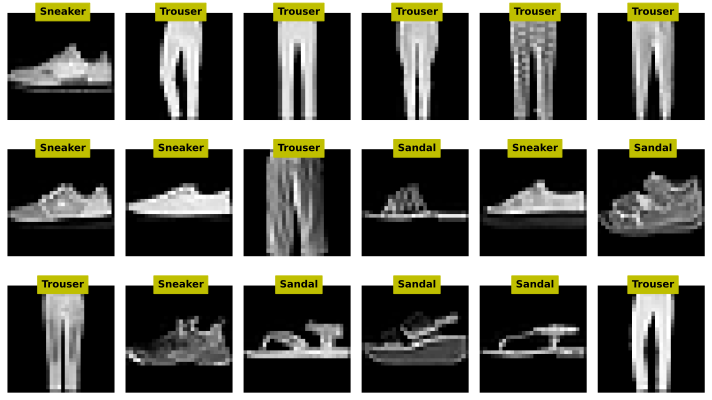

(<torch.utils.data.dataloader.DataLoader at 0x7cfc3377b940>,
 <torch.utils.data.sampler.SubsetRandomSampler at 0x7cfc33778100>)

In [28]:
get_images(True)

## Discriminator Model

In [29]:
class DiscriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear( 28 * 28, 256 )
    self.fc2 = nn.Linear( 256, 256 )
    self.output = nn.Linear( 256, 1 )

  def forward(self, data):
    data = F.leaky_relu( self.fc1(data) )
    data = F.leaky_relu( self.fc2(data) )

    return torch.sigmoid( self.output(data) )

In [30]:
# test run model
dnet = DiscriminatorNet()
y = dnet( torch.rand(10, 784) )
y.shape

torch.Size([10, 1])

## Generator Model

In [31]:
class GeneratorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear( 64, 256 )
    self.fc2 = nn.Linear( 256, 256 )
    self.output = nn.Linear( 256, 784 )

  def forward(self, data):
    data = F.leaky_relu( self.fc1(data) )
    data = F.leaky_relu( self.fc2(data) )

    return torch.tanh( self.output(data) )

In [32]:
# test run model
gnet = GeneratorNet()
y = gnet( torch.rand(10, 64) )
y.shape

torch.Size([10, 784])

## Model training function

1. use large training epochs with small learning rate
2. train disciminator to let it know the real images
3. train disciminator to let it know the fake images
4. combine loss from above 2 train then backprop to disciminator model
5. generate fake images from with generator
6. compute loss by telling the discriminator that generated fake images are real
7. backprop loss to generator model
8. repeat from (2) until training epochs

In [33]:
def train_model():
  data_loader, sampler = get_images()

  # loss function (same for both phases of training)
  lossfun = nn.BCELoss()

  # create instances of the models
  dnet = DiscriminatorNet().to(device)
  gnet = GeneratorNet().to(device)

  # optimizers (same algo but different variables b/c different parameters)
  d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
  g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

  num_epochs = int(50_000 / len(data_loader))

  losses = np.zeros((num_epochs * len(data_loader), 2))
  lossi  = 0

  for epochi in range(num_epochs):

    for data, _ in data_loader:

      # send data to GPU
      data = data.view(batchsize,-1).to(device)

      # labels used for real and fake images
      real_labels = torch.ones(batchsize, 1).to(device)
      fake_labels = torch.zeros(batchsize, 1).to(device)

      # labels used for real and fake images
      real_labels = torch.ones(batchsize, 1).to(device)
      fake_labels = torch.zeros(batchsize, 1).to(device)


      ### ---------------- Train the discriminator ---------------- ###

      # forward pass and loss for REAL pictures
      pred_real   = dnet(data)                      # output of discriminator
      d_loss_real = lossfun(pred_real, real_labels) # all labels are 1

      # forward pass and loss for FAKE pictures
      fake_images = gnet( torch.randn(batchsize, 64).to(device) ) # output of generator
      pred_fake   = dnet(fake_images)                             # pass through discriminator
      d_loss_fake = lossfun(pred_fake, fake_labels)               # all labels are 0

      # collect loss (using combined losses)
      d_loss = d_loss_real + d_loss_fake
      losses[lossi, 0] = d_loss.item()

      # backprop
      d_optimizer.zero_grad()
      d_loss.backward()
      d_optimizer.step()


      ### ---------------- Train the generator ---------------- ###

      # create fake images and compute loss
      fake_images = gnet( torch.randn(batchsize, 64).to(device) )
      pred_fake   = dnet(fake_images)

      # compute and collect loss
      g_loss = lossfun(pred_fake, real_labels)
      losses[lossi, 1] = g_loss.item()

      # backprop
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

      # increment loss counter
      lossi += 1

    # print out a status message
    msg = f'Finished epoch {epochi+1} / {num_epochs}'
    sys.stdout.write('\r' + msg)

  return losses, dnet, gnet

## Lets run the expriment

In [34]:
# create a 1D smoothing filter
def smooth(x, k=15):
  return np.convolve(x, np.ones(k) / k, mode='same')

In [35]:
losses, _, gnet = train_model()

Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Sandal (index 5)
Finished epoch 277 / 277

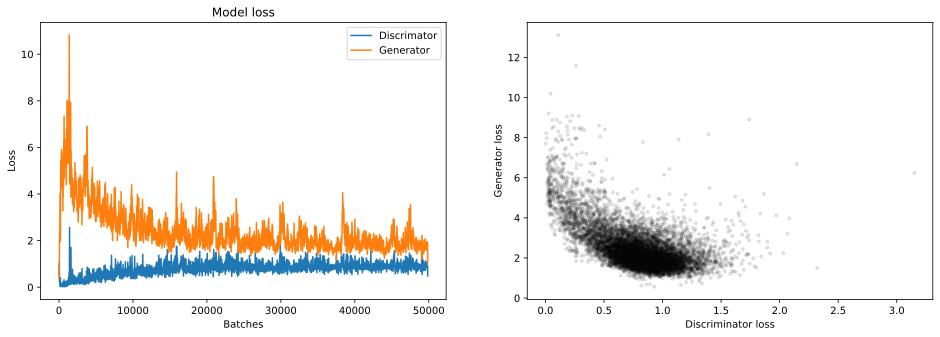

In [36]:
fig,ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,6000])
# ax[0].set_ylim([0, 200])

ax[1].plot(losses[::5,0], losses[::5,1], 'k.', alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

plt.show()

## Visualize the image generated by `GeneratorNet`

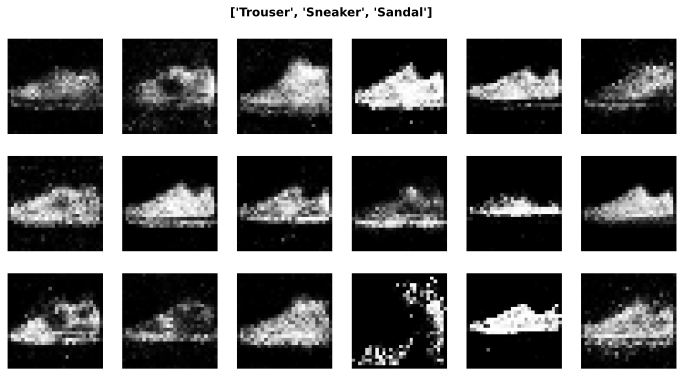

In [37]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(18,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.suptitle(classes2keep, y=.95, fontweight='bold')
plt.show()